# Jet tagging with Quantum Machine Learning @ LHCb
Based on:  
Alessio Gianelle, Donatella Lucchesi, Davide Nicotra, Lorenzo Sestini, & Davide Zuliani. (2021). Quantum Machine Learning for Jet Tagging at the LHCb experiment (v1.0). PyHEP 2021 Workshop. Zenodo. https://doi.org/10.5281/zenodo.5081957

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset
The dataset is stored in two csv files produced using LHCb OpenData tuples that are publicly available.
Test dataset contains also variables needed afterwards for analysis.

_Reference_: LHCb collaboration (2020). Simulated jet samples for quark flavour identification studies. CERN Open Data Portal.  <https://opendata.cern.ch/record/4910>

In [2]:
import pandas as pd
# All Input variables
allvariables = ['idx',                                     # jet index
             'Jet_foundMuon', 'Jet_muon_q', 'Jet_muon_PT', #  global (anti-)muon variables
             'Jet_PT', 'Jet_ETA', 'Jet_PHI',               #  global jet variables
             'mu_Q', 'mu_pTrel','mu_dist',                 # (anti-)muon
             'k_Q', 'k_pTrel','k_dist',                    # (anti-)kaon
             'pi_Q', 'pi_pTrel','pi_dist',                 # (anti-)pion
             'e_Q', 'e_pTrel','e_dist',                    # (anti-)electron
             'p_Q', 'p_pTrel','p_dist',                    # (anti-)proton
             'Jet_QTOT',                                   # Weighted Jet Total Charge
             'Jet_LABEL']                                  # Ground Truth label

# Input variables of the quantum circuit
variables = ['idx',                                        # jet index
             'mu_Q', 'mu_pTrel','mu_dist',                 # (anti-)muon
             'k_Q', 'k_pTrel','k_dist',                    # (anti-)kaon
             'pi_Q', 'pi_pTrel','pi_dist',                 # (anti-)pion
             'e_Q', 'e_pTrel','e_dist',                    # (anti-)electron
             'p_Q', 'p_pTrel','p_dist',                    # (anti-)proton
             'Jet_QTOT',                                   # Weighted Jet Total Charge
             'Jet_LABEL']                                  # Ground Truth label

# Events are split in two subsets for training and testing
trainData = pd.read_csv("./data/trainData.csv")[variables]
testData = pd.read_csv("./data/testData.csv")[allvariables]

In [3]:
trainData

,idx,mu_Q,mu_pTrel,mu_dist,k_Q,k_pTrel,k_dist,pi_Q,pi_pTrel,pi_dist,e_Q,e_pTrel,e_dist,p_Q,p_pTrel,p_dist,Jet_QTOT,Jet_LABEL
0,275885_bbdw50V2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,458.485129,0.248483,-1.0,120.483381,0.027181,0.0,0.000000,0.00000,0.427794,1
1,253842_bbdw50V2,0.0,0.000000,0.000000,1.0,695.258759,0.446457,-1.0,876.600255,0.069136,0.0,0.000000,0.000000,0.0,0.000000,0.00000,-0.032886,1
2,170856_bbup20V2,0.0,0.000000,0.000000,-1.0,1072.012073,0.251426,-1.0,777.083051,0.087772,0.0,0.000000,0.000000,0.0,0.000000,0.00000,-0.818268,0
3,23779_bbup20V2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,-1.0,287.761222,0.331624,-1.0,193.442931,0.465264,0.0,0.000000,0.00000,-0.284538,1
4,54381_bbdw50V2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,-1.0,531.851860,0.092017,-1.0,128.247756,0.454553,0.0,0.000000,0.00000,-0.312699,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221409,125048_bbup20V2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,-1.0,865.147216,0.158171,0.0,0.000000,0.000000,1.0,510.948761,0.19229,-0.158286,0
221410,215630_bbdw20V2,1.0,405.749009,0.164707,1.0,383.944698,0.127527,-1.0,1041.341254,0.141354,0.0,0.000000,0.000000,0.0,0.000000,0.00000,-0.130558,1
221411,134297_bbdw50V2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,576.107465,0.049113,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.599114,0
221412,178748_bbup50V2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,-1.0,802.559349,0.307935,1.0,362.690030,0.071679,0.0,0.000000,0.00000,-0.226076,1


 ## Preprocessing
 The variables need to be preprocessed before the training process. Here we adopt a technique that suited well for our QML application: firstly data are normalized using a StandardScaler, then the arctan function is applied.

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(pd.concat([trainData,testData])[variables[1:-1]])
trainData[variables[1:-1]] = np.arctan(trainData[variables[1:-1]])
testData[variables[1:-1]] = np.arctan(testData[variables[1:-1]])

In [5]:
trainData

,idx,mu_Q,mu_pTrel,mu_dist,k_Q,k_pTrel,k_dist,pi_Q,pi_pTrel,pi_dist,e_Q,e_pTrel,e_dist,p_Q,p_pTrel,p_dist,Jet_QTOT,Jet_LABEL
0,275885_bbdw50V2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.785398,1.568615,0.243550,-0.785398,1.562497,0.027175,0.000000,0.000000,0.000000,0.404235,1
1,253842_bbdw50V2,0.000000,0.000000,0.000000,0.785398,1.569358,0.419904,-0.785398,1.569656,0.069026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.032874,1
2,170856_bbup20V2,0.000000,0.000000,0.000000,-0.785398,1.569864,0.246320,-0.785398,1.569509,0.087548,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.685781,0
3,23779_bbup20V2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.785398,1.567321,0.320211,-0.785398,1.565627,0.435475,0.000000,0.000000,0.000000,-0.277212,1
4,54381_bbdw50V2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.785398,1.568916,0.091759,-0.785398,1.562999,0.426634,0.000000,0.000000,0.000000,-0.303066,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221409,125048_bbup20V2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.785398,1.569640,0.156871,0.000000,0.000000,0.000000,0.785398,1.568839,0.189971,-0.156984,0
221410,215630_bbdw20V2,0.785398,1.568332,0.163241,0.785398,1.568192,0.126842,-0.785398,1.569836,0.140424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.129824,1
221411,134297_bbdw50V2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.785398,1.569061,0.049073,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.539768,0
221412,178748_bbup50V2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.785398,1.569550,0.298721,0.785398,1.568039,0.071557,0.000000,0.000000,0.000000,-0.222338,1


## QML Model
<img width=50% src="https://raw.githubusercontent.com/PennyLaneAI/pennylane/master/doc/_static/pennylane_thin.png"/>

<img src="./img/circuit.png" alt="Circuit" width=50%/>


In [6]:
import pennylane as qml
import tensorflow as tf
n_qubits = 4
n_layers = 4

# default.qubit.tf is a quantum simulator that uses Tensorflow as backend
# it supports back-propagation, which is useful with a large number of
# parameters

dev = qml.device("default.qubit.tf",wires=n_qubits) # Device initialization

# In pennylane, quantum circuits are mostly defined via the qnode decorator
# applied to a function which describes the quantum gates to be applied to 
# each qubit and, finally, the measurement to be performed.
@tf.function
@qml.qnode(dev, interface="tf", diff_method='backprop')
def circuit(inputs,weights):
    
# The AmplitudeEmbedding template implements the embedding of 2**N features
# in N qubits. Amplitudes must be < 0, so a normalization is performed. 
    qml.templates.AmplitudeEmbedding(inputs,wires=range(n_qubits),normalize=True)
    
# The StronglyEntanglingLayers templates implements a variable number of
# layers made of rotation around all the axes and CNOT gates. Rotation angles
# are passed via the weights parameter of dimension (n_layers,n_qubits,3)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(4))
    
# Finally, the expectation value of the Sigma_Z Pauli matrix of the first qubit
# is measured. It will range from -1 to 1 and will be mapped to a label prediction
    return qml.expval(qml.PauliZ(0))

## Keras model
A great feature of Pennylane is that it can be integrated flawlessly inside Keras and PyTorch models. This allows for the developing of hybrid quantum-classical machine learning models. 

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation

# We generate the quantum Keras layer, specifiying the dimension of the
# trainable parameters and of the output of the layer.
quantum_layer = qml.qnn.keras.KerasLayer(circuit,weight_shapes={'weights':(n_layers,n_qubits,3)},output_dim=1)

# Finally, we build a Sequencial model appending a sigmoid function to
# the quantum layer
model = Sequential([quantum_layer,Activation('sigmoid')])

## Training the model

In [8]:
from tensorflow.keras.optimizers import Adam

# Let's pick an optimizer
opt = Adam(learning_rate=0.02)

# We choose the Mean Square Error as our loss function and a binary
# accuracy as our metric
model.compile(opt, loss="mse",metrics=['binary_accuracy']) 

# We fix the size of the training dataset and validation dataset
training_size   = 400
validation_size = 200

# And build a balanced training sample ...
bsample = trainData[trainData.Jet_LABEL == 0].sample(training_size//2)
bbarsample = trainData[trainData.Jet_LABEL == 1].sample(training_size//2)

training_sample = pd.concat([bsample,bbarsample]).sample(frac=1.0)

X = training_sample[variables[1:-1]]
Y = training_sample[variables[-1]]

# And validation sample
val_bsample = testData[testData.Jet_LABEL == 0].sample(validation_size//2)
val_bbarsample = testData[testData.Jet_LABEL == 1].sample(validation_size//2)

validation_sample = pd.concat([val_bsample,val_bbarsample]).sample(frac=1.0)

val_X = validation_sample[variables[1:-1]]
val_Y = validation_sample[variables[-1]]

# Finally, we start the training process
n_epochs = 10
history_fit = model.fit(X,Y,epochs=n_epochs,validation_data=(val_X,val_Y))

Epoch 1/10


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function _gcd_import at 0x7f09d66feb00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function _gcd_import at 0x7f09d66feb00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13/13 [==============================] - 17s 511ms/step - loss: 0.2495 - binary_accuracy: 0.5385 - val_loss: 0.2430 - val_binary_accuracy: 0.5536
Epoch 2/10
13/13 [==============================] - 6s 455ms/step - loss: 0.2415 - binary_accuracy: 0.5601 - val_loss: 0.2404 - val_binary_accuracy: 0.5893
Epoch 3/10
13/13 [

## Training results
Standard training results such as the loss function and the accuracy can be plotted with respect to the number of epochs, both for the training and the evaluation datasets.

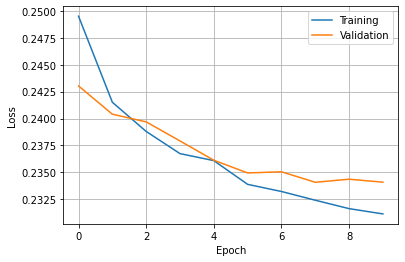

In [9]:
plt.plot(history_fit.history['loss'], label="Training")
plt.plot(history_fit.history['val_loss'], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

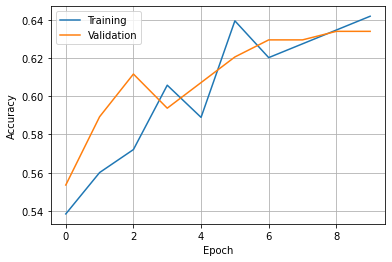

In [10]:
plt.plot(history_fit.history['binary_accuracy'], label="Training")
plt.plot(history_fit.history['val_binary_accuracy'], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

# Testing on AWS Braket
We now perform some testing on a test dataset. The workflow is the following:
- get a test data with a balanced number of $b$ and $\bar{b}$ events
- evaluate the model on the test dataset
- get prediction for each event

**AWS Braket** easily allows to run the trained model on simulators (**SV1, TN1, DM1**) and hardware devices (**Rigetti Aspen-9, IonQ**).

In this example we'll run our model on the Braket local simulator **but running on the hardware is straight-forward!**

In [11]:

# Choose how many events you want to test
testing_size = 1000

# Let's build a balanced testing sample
test_bsample = testData[testData.Jet_LABEL == 0].sample(testing_size//2)
test_bbarsample = testData[testData.Jet_LABEL == 1].sample(testing_size//2)

testing_sample = pd.concat([test_bsample,test_bbarsample]).sample(frac=1.0)

test_X = testing_sample[variables[1:-1]]
test_Y = testing_sample[variables[-1]]

# And let's predict the label with our trained model

optimized_weights = model.get_weights()[0]

n_qubits = 4
n_layers = 4

#device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"
#my_bucket = f"amazon-braket-dzuliani" # the name of the bucket
#my_prefix = "Cineca" # the name of the folder in the bucket
#s3_folder = (my_bucket, my_prefix)
#dev_testing = qml.device('braket.aws.qubit', device_arn=device_arn, wires=4, s3_destination_folder=s3_folder,shots=100)

dev_testing = qml.device("braket.local.qubit",wires=n_qubits) # Device initialization

@qml.qnode(dev_testing)
def circuit(inputs):
    qml.templates.AmplitudeEmbedding(inputs,wires=range(n_qubits),normalize=True)
    qml.templates.StronglyEntanglingLayers(optimized_weights, wires=range(4))

    return qml.expval(qml.PauliZ(0))


test_predY= [circuit(x) for x in test_X.values]
testing_sample['RawPred'] = test_predY
testing_sample['Jet_PREDLABEL'] = np.round(test_predY)

## Prediction distribution
You can plot the prediction distribution for both classes ($b$ and $\bar{b}$) in order to check if a discrimination is possible.

[]

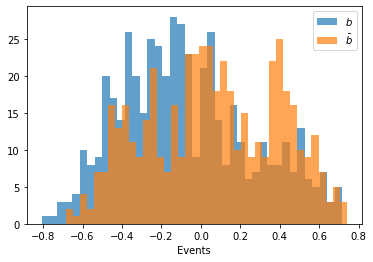

In [12]:
plt.hist(testing_sample[testing_sample['Jet_LABEL'] == 0]['RawPred'],bins=40,alpha=0.7,label="$b$")
plt.hist(testing_sample[testing_sample['Jet_LABEL'] == 1]['RawPred'],bins=40,alpha=0.7,label="$\\bar{b}$")
plt.xlabel("RawPred")
plt.xlabel("Events")
plt.legend()
plt.plot()

## Receiver Operating Characteristic (ROC) curve and Area Under Curve (AUC)
Usual metrics such as ROC curve and AUC can be computed.

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr,tpr, _ = roc_curve(testing_sample['Jet_LABEL'],testing_sample['RawPred'])
auc = roc_auc_score(testing_sample['Jet_LABEL'],testing_sample['RawPred'])

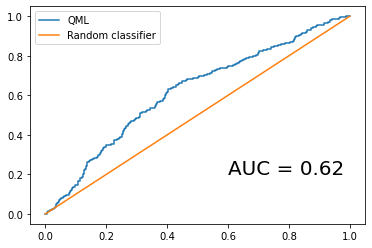

In [14]:
plt.plot(fpr,tpr,label='QML')
plt.plot([0,1],[0,1], label='Random classifier')
plt.text(0.6,0.2,f"AUC = {auc:.2}",fontsize=20)
plt.legend()
plt.show()

## Saving predictions
Once you have tested your dataset you can easily save your model prediction for future analysis.


In [15]:
testing_sample

,idx,Jet_foundMuon,Jet_muon_q,Jet_muon_PT,Jet_PT,Jet_ETA,Jet_PHI,mu_Q,mu_pTrel,mu_dist,...,e_Q,e_pTrel,e_dist,p_Q,p_pTrel,p_dist,Jet_QTOT,Jet_LABEL,RawPred,Jet_PREDLABEL
17457,283872_bbdw50V2,True,-1,14863.855457,41288.065021,2.453152,-1.169764,-0.785398,1.570162,0.100647,...,0.000000,0.000000,0.000000,0.785398,1.566104,0.04585,-0.213635,0,-0.35970987405163896,-0.0
249568,331026_bbup50V2,False,0,-99.000000,49535.468333,3.935590,-0.853078,0.000000,0.000000,0.000000,...,-0.785398,1.547414,0.278306,0.000000,0.000000,0.00000,0.256641,0,0.24349645254533298,0.0
32834,135560_bbup50V2,False,0,-99.000000,47514.384800,3.007671,-2.354583,0.000000,0.000000,0.000000,...,-0.785398,1.403984,0.032416,0.000000,0.000000,0.00000,-0.608823,0,-0.6232591950252784,-1.0
5452,129072_bbdw20V2,False,0,-99.000000,21689.111000,3.204025,2.332690,-0.785398,1.569981,0.276641,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-0.438558,0,-0.3801656526210029,-0.0
68776,225014_bbdw50V2,False,0,-99.000000,50819.707449,3.318982,0.755045,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-0.472431,0,-0.36878097042697205,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6383,211667_bbdw20V2,False,0,-99.000000,27181.188144,3.031480,2.239303,0.000000,0.000000,0.000000,...,-0.785398,1.529035,0.157583,0.000000,0.000000,0.00000,0.522308,0,-0.05281121751974602,-0.0
90971,344662_bbup50V2,False,0,-99.000000,32516.659208,2.441074,-0.566771,0.000000,0.000000,0.000000,...,0.785398,1.557835,0.267041,0.000000,0.000000,0.00000,0.207064,1,0.09758255705990422,0.0
114245,259442_bbup50V2,False,0,-99.000000,51738.177015,2.348098,-1.658055,0.000000,0.000000,0.000000,...,0.785398,1.560969,0.062930,0.000000,0.000000,0.00000,-0.035640,0,0.3644092147047062,0.0
258183,277318_bbdw50V2,False,0,-99.000000,41834.344664,2.901682,-0.430929,-0.785398,1.570211,0.116119,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-0.346200,0,-0.5790073479828495,-1.0


In [16]:
# Finally, we can save our model prediction for future analysis (bbar asymmetry estimation,
# tagging performance analysis, ...)

testing_sample.to_csv("data_with_predictions.csv",index=False)

Once you got your prediction you can use these two functions to apply (ApplyAlgTagging) and check (ApplyAlgChecking) the classifier response with respect to true information.

In [17]:
def ApplyAlgTagging(df, netype="Quantum", mu_cut=5000):
    """
    Performs the algorithm tagging for each jet, and applies a probabilities R
    """
    df['Jet_%s_Charge'%netype] = 0
    tt_Jet_1 = (df["Jet_%sProb"%netype] > 0.5)
    tt_Jet_0 = (df["Jet_%sProb"%netype] < 0.5)
    df.loc[tt_Jet_1,'Jet_%s_Charge'%netype] =  1
    df.loc[tt_Jet_0,'Jet_%s_Charge'%netype] =  0

def ApplyAlgChecking(df, netype="Quantum"):
    """
    Checks the result of the algorithm tagging by comparing the classifier response with the MC-truth.
    """
    df['Jet_%s_Check'%netype] = 0

    tt_correct_jet = df['Jet_%s_Charge'%netype] == df.Jet_MATCHED_CHARGE
    tt_notcorrect_jet = df['Jet_%s_Charge'%netype] != df.Jet_MATCHED_CHARGE

    df.loc[tt_correct_jet, 'Jet_%s_Check'%netype] = 1
    df.loc[tt_notcorrect_jet, 'Jet_%s_Check'%netype] = -1

In [18]:
#rename some variables just for the sake of completeness
testing_sample.rename(columns={"Jet_LABEL": "Jet_MATCHED_CHARGE"}, inplace=True)
testing_sample.rename(columns={"RawPred": "Jet_QuantumProb"}, inplace=True)

#apply algorithm tagging and checking
ApplyAlgTagging(testing_sample, "Quantum")
ApplyAlgChecking(testing_sample, "Quantum")

# Get classifier performances
The "GetAlgPerformances" function extracts the classifier performance and associated uncertainties.
The following quantities are defined:
- efficiency: $ \varepsilon_{eff}=\frac{N_{tag}}{N_{tot}} $
- mistag: $ \varepsilon_{mistag}=\frac{N_{wrong}}{N_{tag}}$
- tagging power: $\varepsilon_{tag}=\varepsilon_{eff}(1-2\varepsilon_{mistag})^2$

Keep in mind that:
- efficiency will always be $100\%$ since the classifier will always classify a jet
- the greater the tagging power, the better the classifier (e.g. the tagging power is directly related to the statistical uncertainty of the $b - \bar{b}$ asymmetry)

In [19]:
# these two functions are used in the error estimitation of the tagging power
def Deps_DNtag(N_tot,N_w,N_tag):
    return 1.0/N_tot * (1 - (float(N_w)**2)/(N_tag**2))

def Deps_DNw(N_tot,N_w,N_tag):
    return 1.0/N_tot * (-4 + 8*float(N_w)/N_tag)


def GetAlgPerformances(jet_df, netype="Quantum"):

    N_tot = len(jet_df)
    N_tag = jet_df['Jet_%s_Check'%netype].value_counts()[1] + jet_df['Jet_%s_Check'%netype].value_counts()[-1]
    N_wrong = jet_df['Jet_%s_Check'%netype].value_counts()[-1]

    #Efficiency
    eps_eff = float(N_tag)/N_tot
    #Efficiency error
    err_eps_eff = np.sqrt(eps_eff*(1-eps_eff)/N_tot)

    #Mistag
    omega = float(N_wrong)/(N_tag)
    #Mistag error
    err_omega  = np.sqrt(omega*(1-omega)/N_tag)

    #Accuracy
    accuracy = 1- omega
    
    #Tagging Power
    eps_tag = (eps_eff * (1-2*omega)**2)
    #Tagging power error
    err_eps_tag = np.sqrt((N_tot*(eps_eff)*(1-eps_eff)) * Deps_DNtag(N_tot,N_wrong,N_tag)**2 + (N_tag*(omega)*(1-omega)) * Deps_DNw(N_tot,N_wrong,N_tag)**2)
    
    return eps_eff,omega,eps_tag,err_eps_eff,err_omega,err_eps_tag,N_tot,accuracy

The function "Analysis" just compute all the quantities described above in different bins of jet $p_T$. So first of all you define jet $p_T$ bins such as they have the same number of jets, and then you compute all the relevant quantities.

In [20]:
bin_centers = []
half_widths = []

omegas = []
err_omegas = []
effs = []
err_effs = []
ptags = []
err_ptags = []
tot = []
accuracies = []

def Analysis(jet_df, netype="Quantum", nbins=8, basepath="", legend=True):

    # Discretize variable into equal-sized buckets using jet PT
    out,bins = pd.qcut(jet_df.Jet_PT,nbins,retbins=True,labels=False)


    for i in range(nbins):
        bin_center = float((bins[i] + bins[i+1])/2)/1000
        half_width = float((bins[i+1] - bins[i])/2)/1000
        bin_centers.append(bin_center)
        half_widths.append(half_width)
    
        eps_eff,omega,eps_tag,err_eps_eff,err_omega,err_eps_tag,N_tot,accuracy = GetAlgPerformances(jet_df[out == i], netype)
        omegas.append(omega*100)
        err_omegas.append(err_omega*100)
        ptags.append(eps_tag*100)
        err_ptags.append(err_eps_tag*100)
        effs.append(eps_eff*100)
        err_effs.append(err_eps_eff*100)

 
    fig = plt.figure(figsize=(6,6))
    plt.errorbar(bin_centers, ptags, xerr=half_widths, yerr=err_ptags, fmt='o', capsize=2, ms=8)
    plt.xlabel("$\mathrm{P_{T} \ (GeV)}$")
    plt.ylabel("$\mathrm{\epsilon_{tag} \ (\%)}$")

    plt.minorticks_on()
    plt.figtext(0.585,0.790,"LHCb Simulation\nOpen Data", ma='right', fontsize=16)
    plt.show()

    #fig = plt.figure(figsize=(6,6))
    #plt.errorbar(bin_centers, effs, xerr=half_widths, yerr=err_effs, fmt='o', capsize=2, ms=8)
    #plt.xlabel("$\mathrm{P_{T} \ (GeV)}$")
    #plt.ylabel("$\mathrm{\epsilon_{eff} \ (\%)}$")

    #plt.minorticks_on()
    #plt.figtext(0.585,0.790,"LHCb Simulation\nOpen Data", ma='right', fontsize=16)
    #plt.show()

    fig = plt.figure(figsize=(6,6))
    plt.errorbar(bin_centers, omegas, xerr=half_widths, yerr=err_omegas, fmt='o', capsize=2, ms=8)
    plt.xlabel("$\mathrm{P_{T} \ (GeV)}$")
    plt.ylabel("$\mathrm{\epsilon_{mistag} \ (\%)}$")

    plt.minorticks_on()
    plt.figtext(0.585,0.790,"LHCb Simulation\nOpen Data", ma='right', fontsize=16)
    plt.show()

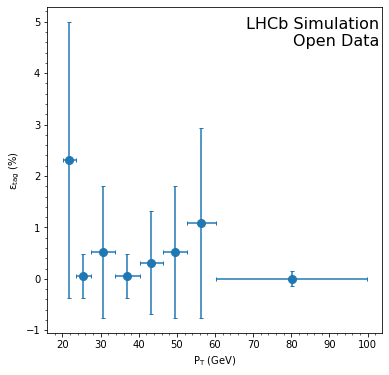

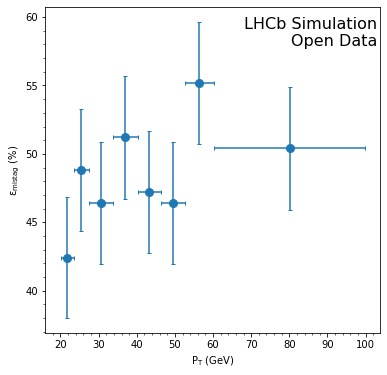

In [21]:
Analysis(testing_sample)

# Final considerations
At this point you can do several things to improve this exercise:
- choose different circuit geometries
- choose a different set of input variables
- train and test on more data
- compare this quantum classifier with other "classical" classifier